# Recursive forward-backward artefact removal algorithm with inter-band data augmentation on satellite imagery
To select the best possible image when the satellite does not have data available, combined with cloud removal based on LeastCC, and nearest interpolation for spatial resolution. In order to find the optimal conditions that we expect to improve our results, we plan to augment our dataset with inter-band data and run a variety of different experiments, including the following with different configurations:  Contrast limited adaptive histogram equalization (CLAHE), RGBShift, RandomBrightnessContrast, random cropping, horizontal and vertical flips, gaussian noise, adding hue and saturation to each channel.

- **Goal**: Improve overall performance of ML-DL models by 

        - reducing the data augmentation probability

        - Adding gaussian blur 
        
        - In parallel, ML models may implement horizontal/vertical 
        
- Remarks:

        - Final images are normalized in range 0-1 and set to float32 to preserve bit-depth from raw data.
        - To replace "bad" images, the first thing this code does is to copy the full folder containing the images to analyze. This is not necesary, in the future can just read images and store augmented images instead.

In [97]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import os
import copy
import shutil
import random
from skimage import io
from skimage.transform import rescale, resize
import skimage.exposure
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random


def read_tiff(img_path, resize_ratio=None, resizing = True, normalize=True, printing=True):
  img = io.imread(img_path)
  img_F =img.copy()
  if resize_ratio:
    img_F = rescale(img, resize_ratio, anti_aliasing=True)
  if resizing:
    img_F = resize(img_F, (750,750), anti_aliasing=True)
  
  path_img = os.path.basename(img_path)
  if normalize:
    CHANNELS = range(12)
    img_F = np.dstack([
        skimage.exposure.rescale_intensity(img_F[:,:,c], out_range=(0, 1)) 
        for c in CHANNELS])
  if printing:
    print(f"(origin shape: {path_img}: {img.shape} -> rescale: {str(img_F.shape)}) - Range -> [{img_F.min(), img_F.max()}]")
  return img_F

- Perform tests over a municipality with low-pixel content, such as 230001

In [98]:
# Define path where datasets are located
root = "/home/sebasmos/Desktop/DATASETS/"

# Define name of source dataset
source_dataset = "DATASET_improved_10_cities"

# For testing purpposes on this notebook, select 1 municipality by selecting its name
code = 23001

# Define target dataset
target_dataset = "DATASET_augmented_v2_gaussian_blur"

In [99]:
baseline = os.path.join(root, source_dataset, str(code))
aug_root =  os.path.join(root, target_dataset,  str(code))
print(f"root: ", root)
print(f"baseline: ", baseline)
print(f"aug_root: ", aug_root)
CLEAN = False
if CLEAN:
    shutil.rmtree(aug_root)
else: 
    try:
        shutil.copytree(baseline, aug_root)
    except:
        pass
images = sorted(glob.glob(os.path.join(baseline)+"/*.tiff")) # use sorted to align images temporally back-forwards
print(f"Total # images found on source dataset: ", len(images))

root:  /home/sebasmos/Desktop/DATASETS/
baseline:  /home/sebasmos/Desktop/DATASETS/DATASET_improved_10_cities/23001
aug_root:  /home/sebasmos/Desktop/DATASETS/DATASET_augmented_v2_gaussian_blur/23001
Total # images found on source dataset:  165


Compared to PART-1, we add new parameter p to parametrize the data augmentation probability of occurance 

In [100]:
def augment_satellite_replaced_img_compose_aug(path, resize_ratio=(1, 1, 1)):
        """
        augment_satellite_replaced_img augmentes images given image path on RGB channels only, given probability p
        https://albumentations.ai/docs/getting_started/image_augmentation/?query=RandomBrightnessContrast
        ::param path: image path

        """
        transform = A.Compose([
        A.RandomRotate90(),
        #A.Flip(),
        #A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        ])

        image_name = path.split("/")[-1][:-5]
        img = (255*read_tiff(path, resize_ratio=resize_ratio, resizing = True, normalize=True, printing=True)).astype("uint8")
        B =img[:,:,1:4][:,:,0]
        G =img[:,:,1:4][:,:,1]
        R =img[:,:,1:4][:,:,2]
        RGB_img = np.stack([R,G,B]).transpose(2,1,0)
        img[:,:,1:4] = transform(image=RGB_img)['image']
        return img
        

(origin shape: image_2017-05-07.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
(750, 750, 3)
Range of values for augmented image: Min (1), Max (250)
(origin shape: image_2017-05-14.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
(750, 750, 3)
Range of values for augmented image: Min (0), Max (228)
(origin shape: image_2017-05-21.tiff: (747, 745, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
(750, 750, 3)
Range of values for augmented image: Min (0), Max (255)


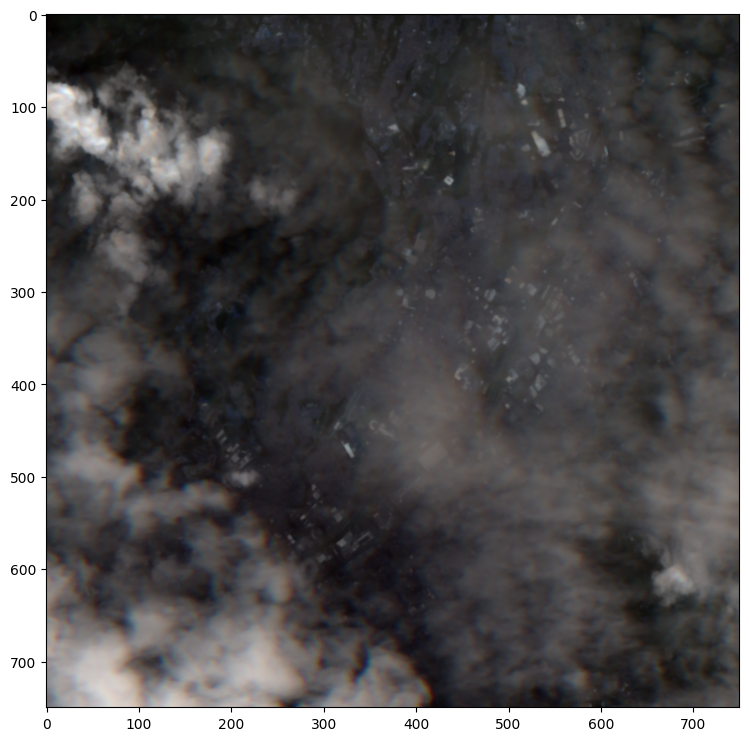

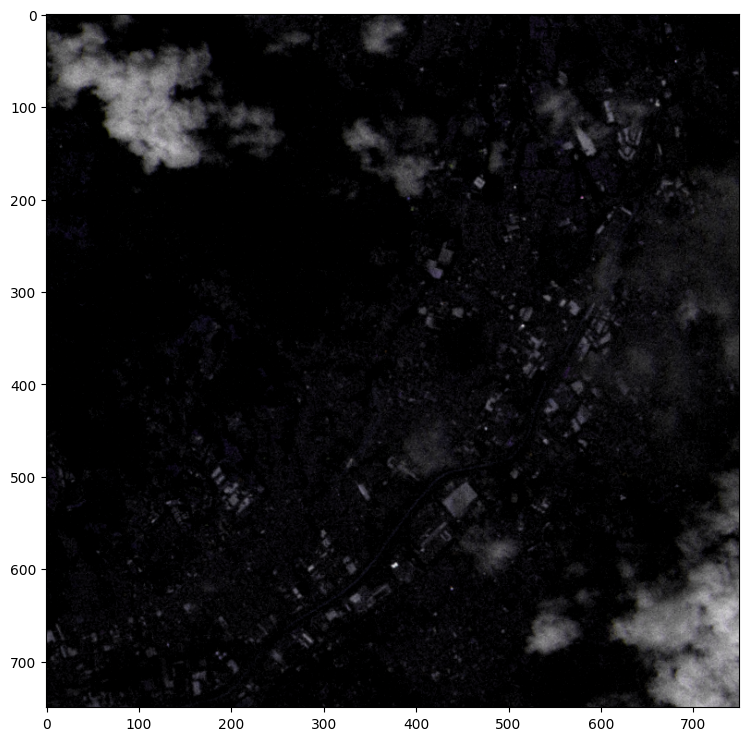

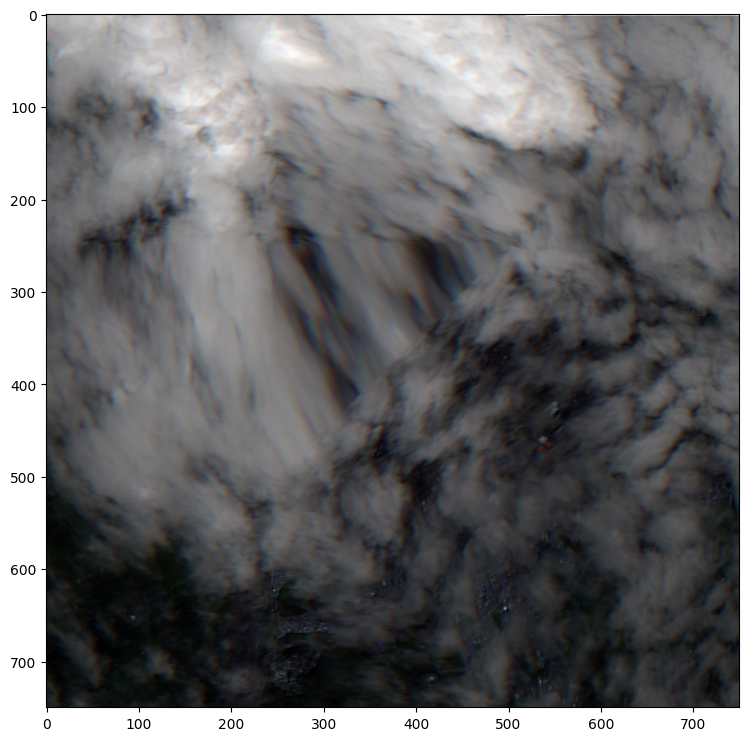

In [101]:
# Visualize results of augmented images here with sample data located in ./data/sample_sentinel2
test_local = sorted(glob.glob(os.path.join("../data/sample_sentinel2")+"/*.tiff"))

for idx, path in enumerate(test_local):

    img = augment_satellite_replaced_img(test_local[idx])

    plt.figure(figsize=(9, 9))
    print(img[:,:,1:4].shape)
    print(f"Range of values for augmented image: Min ({img[:,:,1:4].min()}), Max ({img[:,:,1:4].max()})")
    plt.imshow(img[:,:,1:4])
    #if idx==10:
    #    break
#"""

### Improving satellite imagery 
Find the closest image sideways under threshold, apply transformation and replace. 

In [102]:
def find_closest_temporal_neighbor(path, images, threshold, resize_ratio = None, resizing = False, normalize = True, printing= False):
    """
    Find the closest temporal neighbor for an image that does not follow np.sum(img)>threshold. The best image is chosen 
    based on the distance calculated by the counters upward and backward, the closest to the current image will be replaced.

    ::param path: current image to be exhanged
    ::param images: list of images in current folder containing collection of possible candidates
    ::param threshold: minimum threshold to choose image. Integer representing the sum of pixels across width/height 

    return  image: the best possible replacement for current image.
    """
    upward = 0
    backward = 0
    current_idx = images.index(path)
    t1 = upward + current_idx 
    t2 = current_idx - backward
    neighborUp = ""
    neighborDown = ""
    img_up = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    img_down = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    # Analize future images and initialize counter
    while t1<=len(images) and np.sum(img_up)<threshold:
        t1+=1
        upward+=1
        img_up = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        neighborUp = images[t1]
    # Analize images in the past and initialize counter
    while t2>=0 and np.sum(img_down)<threshold:
        # if index starts off from 0, bound limits
        t2 = int([0 if t2==0 else t2-1][0]) 
        backward+=1
        img_down = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        neighborDown = images[t2]
        # If t2 = 0 and np.sum(image[t2])<0 while np.sum(image[t1])>threshold, 
        # choose upward by making backward>upward so upward is taken
        if t2==0 and np.sum(img_down)<=threshold:
            backward=upward+1
            t2=t1
            break
    current = os.path.join(images[current_idx].split("/")[-2:][0], images[current_idx].split("/")[-2:][1])
    f_img = os.path.join(images[t1].split("/")[-2:][0], images[t1].split("/")[-2:][1])
    b_img = os.path.join(images[t2].split("/")[-2:][0], images[t2].split("/")[-2:][1])
    
    if upward<backward :
        img = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img_up)>=threshold, "image < threshold"
        print(f"-->[FORWARD] - image {current} will be replaced with {f_img} - Temporal distance = [Forward = {upward}, backward = {backward}]")
        return augment_satellite_replaced_img(images[t1])
    elif upward>backward:
        img = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img_down)>=threshold, "image < threshold"
        print(f"-->[BACKWARDS] - image {current} will be replaced with {b_img} - Temporal distance = [Forward = {upward}, backward = {backward}]")
        return augment_satellite_replaced_img(images[t2])
    elif upward==backward:
        r = [t1 if random.choice(["t1","t2"]) == "t1" else t2][0]
        random_img = os.path.join(images[r].split("/")[-2:][0], images[r].split("/")[-2:][1])
        img = read_tiff(images[r], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        print(f"-->[EQUIDISTANT] - image {current} will be replaced with {random_img} - Temporal distance = [Forward = {upward} = backward = {backward}]")
        return augment_satellite_replaced_img(images[r])

-->[FORWARD] - image 23001/image_2015-11-01.tiff will be replaced with 23001/image_2016-03-20.tiff - Temporal distance = [Forward = 20, backward = 21]
(origin shape: image_2016-03-20.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
[0] Storing augmented image version of 23001/image_2015-11-01.tiff in: /home/sebasmos/Desktop/DATASETS/DATASET_augmented_v2_gaussian_blur/23001/image_2015-11-01.tiff
(750, 750, 12)
(750, 750, 3)
-->[FORWARD] - image 23001/image_2015-11-08.tiff will be replaced with 23001/image_2016-03-20.tiff - Temporal distance = [Forward = 19, backward = 20]
(origin shape: image_2016-03-20.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
[1] Storing augmented image version of 23001/image_2015-11-08.tiff in: /home/sebasmos/Desktop/DATASETS/DATASET_augmented_v2_gaussian_blur/23001/image_2015-11-08.tiff
(750, 750, 12)
(750, 750, 3)
-->[FORWARD] - image 23001/image_2015-11-15.tiff will be replaced with 23001/image_2016-03-20.tiff

KeyboardInterrupt: 

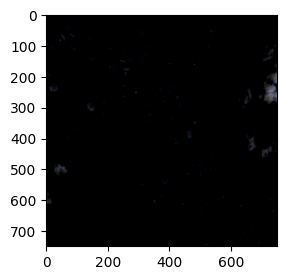

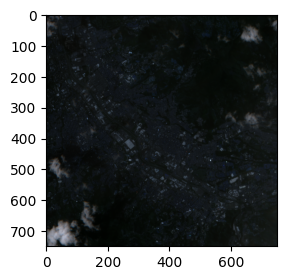

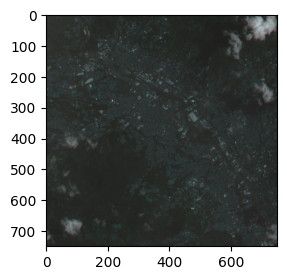

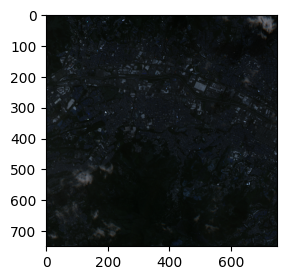

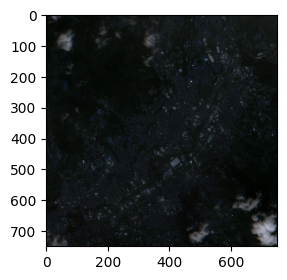

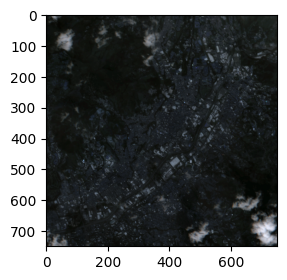

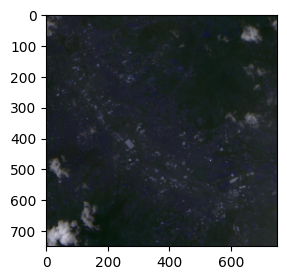

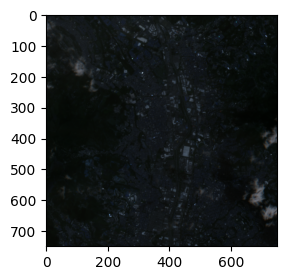

In [103]:
from os.path import exists

resize_ratio=(1, 1, 1)
resize_ratio = None
resizing = False
normalize = True
printing= False
count = 0
threshold = 5
neighbor = ""
for path in images:
    image_name = os.path.join(path.split("/")[-2:][0], path.split("/")[-2:][1])
    img = read_tiff(path, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    if np.sum(img)<threshold:
        # if image content is lower than threshold, replace with the "best" image
        img = find_closest_temporal_neighbor(path, images, threshold, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img)>=threshold, "img is above threshold"
        aug_path = os.path.join(aug_root, path.split("/")[-2:][1])
        print(f"[{count}] Storing augmented image version of {image_name} in: {aug_path}")
        print(img.shape)
        
        if exists(aug_path):
            os.remove(aug_path)
            io.imsave(aug_path, img)
        else: 
            io.imsave(aug_path, img)
        
        if count <=10:    
            plt.figure(figsize=(9, 3))
            print(img[:,:,1:4].shape)
            plt.imshow(img[:,:,1:4])
        
    else:
        print(f"[{count}] - Image {path} ramains unchanged..")
    count+=1
    #if count==5:
    #    break
images = sorted(glob.glob(os.path.join(aug_root)+"/*.tiff")) # use sorted to align images temporally back-forwards
print(f"Total # images: ", len(images))

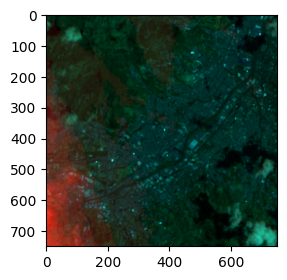

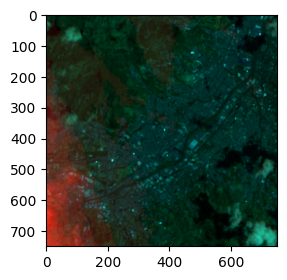

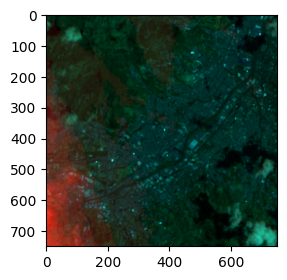

In [ ]:
images = sorted(glob.glob(os.path.join(aug_root)+"/*.tiff")) # use sorted to align images temporally back-forwards
for path in images[:3]:
    img = read_tiff(path, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    plt.figure(figsize=(9, 3))
    bands = [9,10,11]
    #print(img[:,:,1:4].shape)
    plt.imshow(img[:,:,bands])

In [ ]:
aug_path = os.path.join(aug_root, image_name)

In [ ]:
path

'/home/sebasmos/Desktop/DATASETS/DATASET_augmented_v2_gaussian_blur/23001/image_2015-11-15.tiff'

In [ ]:
aug_path

'/home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/23001/image_2015-12-13.tiff'

In [ ]:
aug_root

'/home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001'

1
